In [105]:
import os
import os.path as osp
import numpy as np
import pandas as pd
import scipy
import scipy.stats
from scipy.signal import argrelextrema, find_peaks
from tqdm import tqdm
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings('ignore')
%matplotlib inline

In [2]:
def load_pred(pred_dir, ct, chrom, pred_len=200, avg_stripe=False):
    file = osp.join(pred_dir, ct, 'prediction_{}_chr{}.npz'.format(ct, chrom))
    temp = np.load(file)['arr_0']
    chrom_len = temp.shape[0]
    prep = np.insert(temp, pred_len, 0, axis=1)
    mat = np.array([
        np.insert(np.zeros(chrom_len+pred_len+1), i, prep[i]) for i in range(chrom_len)
    ])
    summed = np.vstack((
        np.zeros((pred_len, mat.shape[1])), mat
    )).T[:chrom_len+pred_len, :chrom_len+pred_len]
    if avg_stripe:
        summed = (summed + np.vstack((
            np.zeros((pred_len, mat.shape[1])), mat
        ))[:chrom_len+pred_len, :chrom_len+pred_len])/2
    
    return summed[pred_len:-pred_len, pred_len:-pred_len]

In [3]:
chrom = 16
pred_dir = '/data/leslie/suny4/predictions/chromafold/'
ct = 'darko_wt_cb'

pred = load_pred(pred_dir, ct, chrom, avg_stripe=True)
pred_norm = (pred - pred.mean()) / pred.std()

lim = 4
lim_norm = (lim - pred.mean()) / pred.std()

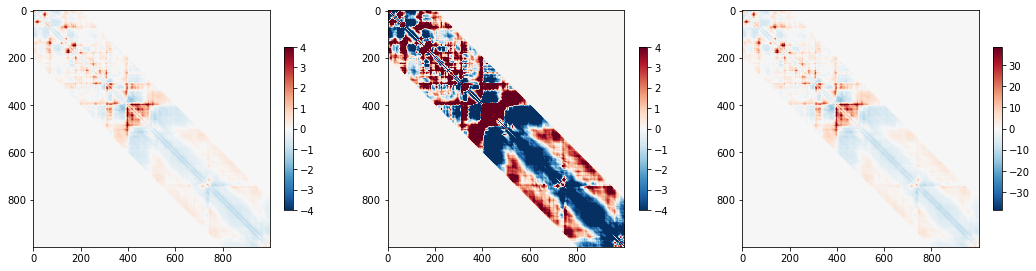

In [4]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 6))
img = ax1.imshow(pred[2000:3000, 2000:3000], cmap='RdBu_r', vmax=lim, vmin=-lim)
plt.colorbar(img, ax=ax1, shrink=0.5)
img = ax2.imshow(pred_norm[2000:3000, 2000:3000], cmap='RdBu_r', vmax=lim, vmin=-lim)
plt.colorbar(img, ax=ax2, shrink=0.5)
img = ax3.imshow(pred_norm[2000:3000, 2000:3000], cmap='RdBu_r', vmax=lim_norm, vmin=-lim_norm)
plt.colorbar(img, ax=ax3, shrink=0.5)

plt.show()

In [53]:
def topdom(mat, size):
    padmat = np.pad(mat, size, mode='constant', constant_values=np.nan)
    dim = padmat.shape[0]
    signal = np.array([
        np.nanmean(padmat[i-size:i+size, i-size:i+size]) for i in range(dim)
    ][size:-size])
    
    return signal

In [54]:
pred_norm.shape

(9320, 9320)

In [55]:
td10 = topdom(pred_norm, 10)
td25 = topdom(pred_norm, 25)
td50 = topdom(pred_norm, 50)
td75 = topdom(pred_norm, 75)
td100 = topdom(pred_norm, 100)

In [56]:
td10.shape

(9320,)

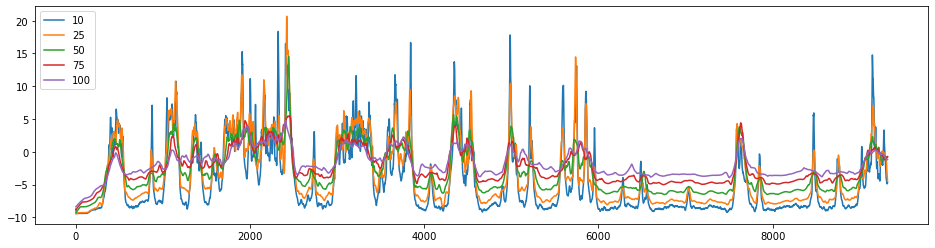

In [57]:
plt.figure(figsize=(16,4))
plt.plot(td10, label='10')
plt.plot(td25, label='25')
plt.plot(td50, label='50')
plt.plot(td75, label='75')
plt.plot(td100, label='100')
plt.legend()
plt.show()

In [91]:
sizes = np.linspace(5, 100, num=50, dtype=int)

In [92]:
tads = np.array([topdom(pred_norm, i) for i in tqdm(sizes)])

100%|██████████| 50/50 [00:33<00:00,  1.49it/s]


In [93]:
tads.shape

(50, 9320)

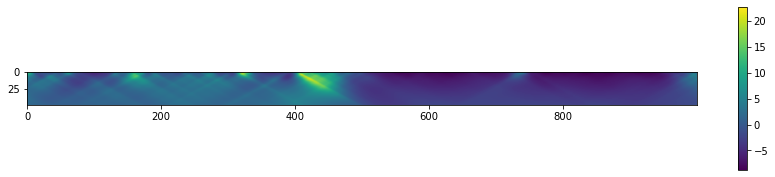

In [148]:
plt.figure(figsize=(15,3))
plt.imshow(tads[:, 2000:3000])
plt.colorbar()
plt.show()

In [197]:
rows = []
idxs = []
for i in range(50):
    idx = find_peaks(tads[i], distance=2, prominence=(0.25, ))[0]
    row = np.full_like(idx, i)
    rows.append(row)
    idxs.append(idx)
tad_pos = np.array([
    np.concatenate(rows, axis=None),
    np.concatenate(idxs, axis=None)
])
tad_pos

array([[   0,    0,    0, ...,   49,   49,   49],
       [ 379,  403,  460, ..., 8874, 9114, 9183]])

In [198]:
coords = np.array([
    tad_pos[1] - sizes[tad_pos[0]],
    tad_pos[1] + sizes[tad_pos[0]]
])
pltcoords = coords[:, coords[0]>2200]
pltcoords = pltcoords[:, pltcoords[1]<2600]
pltcoords -= 2200

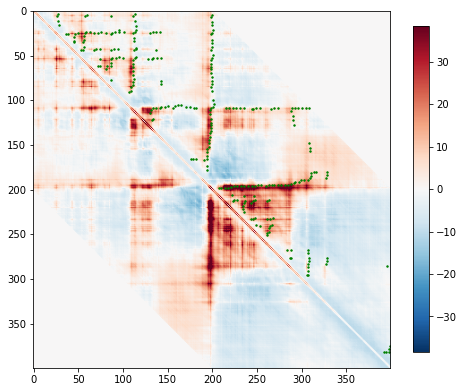

In [199]:
plt.figure(figsize=(8, 8))
plt.imshow(pred_norm[2200:2600, 2200:2600], cmap='RdBu_r', vmax=lim_norm, vmin=-lim_norm)
plt.colorbar(shrink=0.75)
plt.scatter(pltcoords[1], pltcoords[0], s=2, color='green')
plt.show()